<a href="https://colab.research.google.com/github/kelvinNjoroge12/Recipe/blob/main/IS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
!pip install tensorflow==2.15 keras==2.15 tensorflow-addons==0.21
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import cv2
import os

In [174]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [175]:
#define the path and split your data into training and validation split
dataset=tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/IS Project/IS Project/Micro_Organism")
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/IS Project/IS Project/Micro_Organism",
        validation_split=0.2,
        subset="training",
        seed=123)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/IS Project/IS Project/Micro_Organism",
        validation_split=0.2,
        subset="validation",
        seed=123)

test = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/IS Project/IS Project/Micro_Organism",
    seed=123,
    image_size=(256, 256),
    batch_size= 34
)


Found 631 files belonging to 4 classes.
Found 631 files belonging to 4 classes.
Using 505 files for training.
Found 631 files belonging to 4 classes.
Using 126 files for validation.
Found 631 files belonging to 4 classes.


In [176]:
import tensorflow_datasets as tfds

batch_size = 34

dataset_name = dataset
class_names = dataset.class_names
print(class_names)


['Bacteria', 'Cnidaria', 'Fungi', 'Protozoa']


In [177]:
val_batches = tf.data.experimental.cardinality(ds_validation)
test_dataset = ds_validation.take(val_batches // 4)
validation_dataset = ds_validation.skip(val_batches // 4)

In [178]:
size = (256, 256)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val= ds_validation.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = test_dataset.map(lambda image, label: (tf.image.resize(image, size), label))


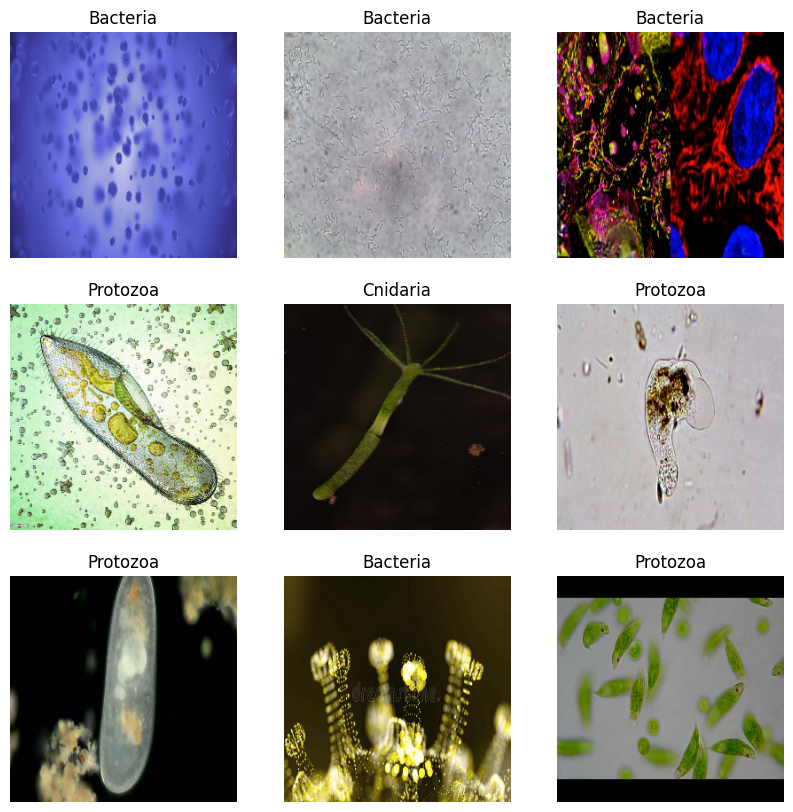

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [180]:
# preprocessing to increase the instances of images
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


image = Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(height_factor=(-0.2, -0.3), width_factor=(-0.2, -0.3), interpolation='bilinear'),
    layers.RandomContrast(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name="image",
)


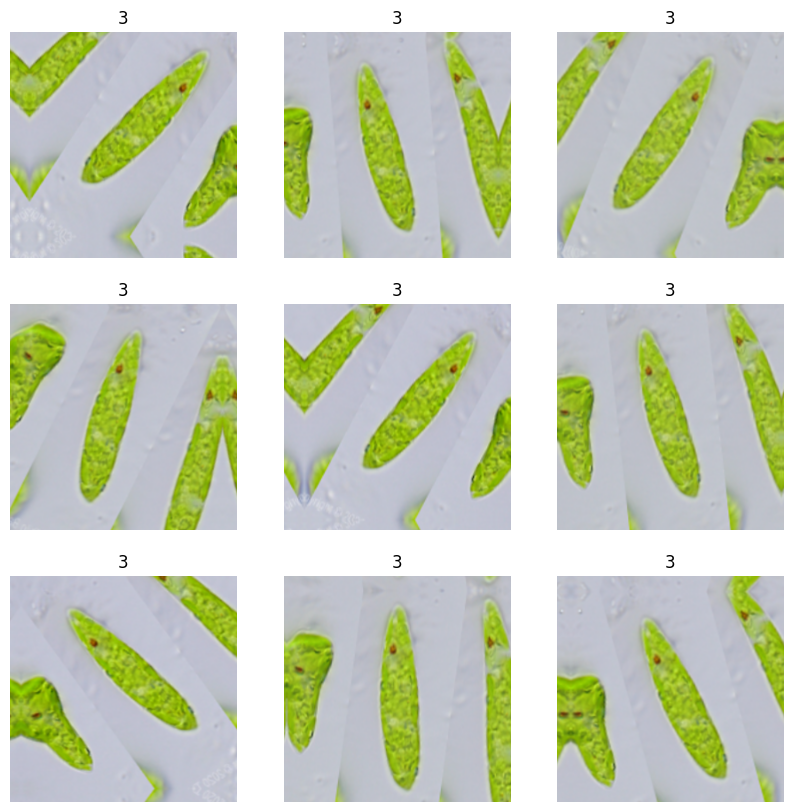

In [181]:
import numpy as np


for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]

    # Fix: Use int instead of np.int
    def f(x):
        return int(x)

    f2 = np.vectorize(f)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        augmented_image = image(
            tf.expand_dims(first_image, 0), training=True
        )

        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(f2(labels[0]))
        plt.axis("off")

plt.show()

In [182]:
NUM_CLASSES=len(class_names)

In [183]:
import tensorflow_addons as tfa

In [184]:

def input_preprocess(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

ds_train = ds_train.map(input_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(input_preprocess)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

In [185]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [186]:
model = tf.keras.models.Sequential([
    base_model,  # Add MobileNetV2
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])


In [187]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [188]:

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/IS Project/IS Project/Micro_Organism',
    image_size=(256, 256),
    batch_size=34
)
ds_val = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/IS Project/IS Project/Micro_Organism',
    image_size=(256, 256),
    batch_size=34
)

Found 631 files belonging to 4 classes.
Found 631 files belonging to 4 classes.


In [189]:

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 10,verbose = 1)

model_cp = ModelCheckpoint(filepath="/content/gdrive/MyDrive/IS Project", monitor = "val_accuracy",
                           save_best_only = True,
                           save_weights_only=False,
                           verbose = 1)

In [190]:
print("Classes in dataset:", ds_train.class_names)

Classes in dataset: ['Bacteria', 'Cnidaria', 'Fungi', 'Protozoa']


In [191]:
# Callbacks (Early Stopping and Model Checkpoint)
model_cp = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


In [192]:
for x, y in ds_test.take(1):
    print(y.shape)

(32, 4)


In [193]:
print(model.loss)

sparse_categorical_crossentropy


In [194]:
def convert_to_sparse(image, label):
    return image, tf.argmax(label, axis=-1)

ds_test = ds_test.map(lambda x, y: convert_to_sparse(x, y))

In [195]:
# Train the model
history = model.fit(ds_train, validation_data=ds_validation, epochs=20)

Epoch 1/20
19/19 [==============================] - 99s 4s/step - loss: 1.3919 - accuracy: 0.4675 - val_loss: 0.9545 - val_accuracy: 0.6111
Epoch 2/20
19/19 [==============================] - 103s 5s/step - loss: 0.9556 - accuracy: 0.6038 - val_loss: 0.7875 - val_accuracy: 0.6825
Epoch 3/20
19/19 [==============================] - 73s 3s/step - loss: 0.8400 - accuracy: 0.6513 - val_loss: 0.6872 - val_accuracy: 0.7381
Epoch 4/20
19/19 [==============================] - 56s 3s/step - loss: 0.7591 - accuracy: 0.6799 - val_loss: 0.6553 - val_accuracy: 0.7540
Epoch 5/20
19/19 [==============================] - 57s 3s/step - loss: 0.7097 - accuracy: 0.7084 - val_loss: 0.6001 - val_accuracy: 0.7698
Epoch 6/20
19/19 [==============================] - 56s 3s/step - loss: 0.6515 - accuracy: 0.7369 - val_loss: 0.5887 - val_accuracy: 0.7619
Epoch 7/20
19/19 [==============================] - 56s 3s/step - loss: 0.5931 - accuracy: 0.7765 - val_loss: 0.5082 - val_accuracy: 0.7937
Epoch 8/20
19/19 [=

In [196]:
from tensorflow_addons.metrics import CohenKappa
from sklearn.metrics import precision_score, recall_score, f1_score

cohen_kappa = CohenKappa(num_classes=4, sparse_labels=True)

# Model Evaluation
loss, accuracy = model.evaluate(test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

y_true_list = []
y_pred_list = []

for x, y in test:
    y_true_list.append(y.numpy())
    y_pred_list.append(model.predict(x))

# Convert lists to numpy arrays
y_true = np.concatenate(y_true_list, axis=0)
y_pred_probs = np.concatenate(y_pred_list, axis=0)

print("Shape of y_true:", y_true.shape)

if len(y_true.shape) == 1:
    y_true_final = y_true.astype(int)
else:
    y_true_final = y_true.argmax(axis=1)

y_pred = np.argmax(y_pred_probs, axis=1)

cohen_kappa.update_state(y_true_final, y_pred)
kappa_score = cohen_kappa.result().numpy()

precision = precision_score(y_true_final, y_pred, average='macro')
recall = recall_score(y_true_final, y_pred, average='macro')
f1 = f1_score(y_true_final, y_pred, average='macro')

# Print results
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print("Cohen's Kappa:", kappa_score)

19/19 [==============================] - 48s 2s/step - loss: 0.1330 - accuracy: 0.9921
Test Loss: 0.13295310735702515
Test Accuracy: 0.9920760989189148
1/1 [==============================] - 2s 2s/step
Shape of y_true: (631,)
Precision: 0.9927859938285543
Recall: 0.9896726873244945
F1 Score: 0.9912137478607389
Cohen's Kappa: 0.98796797


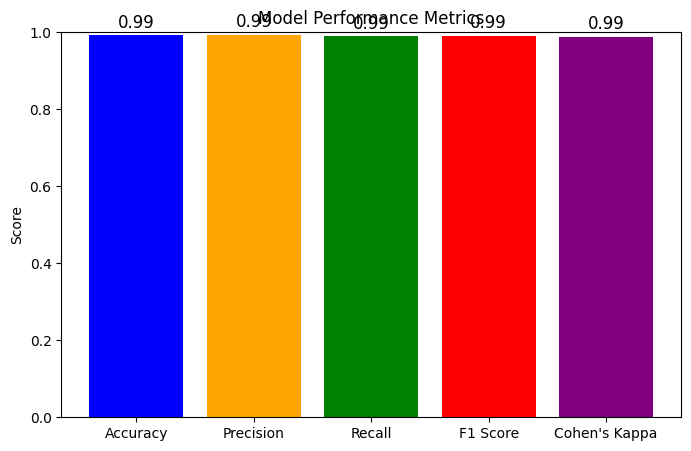

In [197]:
# Define metric names and values
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Cohen's Kappa"]
values = [accuracy, precision, recall, f1, kappa_score]

# Plot bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylim(0, 1)  # Metrics range from 0 to 1
plt.ylabel("Score")
plt.title("Model Performance Metrics")

# Annotate values on bars
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

plt.show()
